In [3]:
from ete3 import Tree
import matplotlib as mplt
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors_mplt
import numpy as np
import warnings
from adjustText import adjust_text
import statsmodels.stats.proportion as ssp
pd.options.mode.chained_assignment = None

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''Truncates cmap for given range'''
    new_cmap = colors_mplt.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_parental_age_effects(mu_g, G_f, G_m, n_e, alpha_p):
    '''Returns parental age effects given:
    (I)   Per generation rate (mu_g)
    (II)  Sex-specific generation times (G_*)
    (III) Ratio of paternal age effects in (alpha_p)
    (IV)  Early embryonic mutations (n_e)'''
    
    n = 2*mu_g - 2*n_e
    d = G_f + alpha_p*G_m
    mu_f = n/d
    mu_m = alpha_p*mu_f
    return mu_f, mu_m

def predict_alpha(mu_f, mu_m, G_f, G_m, n_e):
    '''Predicts alpha given:
    (I)   Parental age effects (mu_f, mu_m)
    (II)  Sex-specific generation times (G_*)
    (III) Early embryonic mutations (n_e)'''
    
    maternal = G_f*mu_f + n_e
    paternal = G_m*mu_m + n_e
    return paternal/maternal

def identity_line(ax=None, ls='--', *args, **kwargs):
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

def nearest_node2leaf(phylo):
    node2leaf = {}
    for node in phylo.traverse(strategy="levelorder"):
        if not node.is_leaf():
            for child in node.get_children():
                if child.is_leaf():
                    node2leaf[child.name] = node.name
    return node2leaf

def branch_specific_length(sp, node2leaf, phylo):
    dist = phylo.get_distance(sp, node2leaf[sp])
    return dist

def add_binomial_CIs(df):
    '''Adds binomial CIs to counts of Paternal vs. Maternal DNMs'''

    ci_df = pd.DataFrame()
    
    for i,r in df.iterrows():
        paternal, maternal = r.Paternal, r.Maternal
        ci = ssp.proportion_confint(paternal, paternal+maternal)
        estimates = [ci[0]/(1-ci[0]),paternal/maternal,ci[1]/(1-ci[1])]
        ci_df = pd.concat([ci_df, pd.DataFrame(estimates).transpose()])

    ci_df.columns = ["low","point","high"]
    ci_df = ci_df.reset_index(drop=True)
    return pd.concat([df, ci_df],axis=1)

Read subsitution rates and split times in TimeTree

In [3]:
rate_phylo = Tree("./../trees/Mammals_phast.nh", format=1)
time_phylo = Tree("./../trees/mammals241.TimeTree.nwk", format=1)

Read DNM data

In [1]:
dnms = pd.read_csv("../data/dnm_est_mutrate.tsv",sep="\t")

In [5]:
get_parental_age_effects(1.290000e-08, 31.626670, 27.600000, 5/3e9, 4)

(1.5818625238954534e-10, 6.327450095581813e-10)

In [6]:
n_e = 5/3e9

data = pd.DataFrame()
for cn,df in dnms.groupby("Common Name"):
    
    # Collapse DNMs from same species
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    p_age = np.average(df["Mean Paternal Age at Conception (y)"].values, weights=df["Num Trios"])
    m_age = np.average(df["Mean Maternal Age at Conception (y)"].values, weights=df["Num Trios"])
    alpha = p/m
    sp = "_".join(df["Species"].values[0].split()[:2])
    gen_rate = df["Mutation rate per generation"].mean()
    trios = df["Num Trios"].sum()
    
    if sp=="Ficedula_albicollis":
        c_df = pd.DataFrame([sp, cn, np.mean([p_age,m_age]), p, m, alpha, mu_f, mu_m, np.nan, p+m, trios]).transpose()
        c_df.columns = ["Species", "Common_name", "Age", "Paternal", "Maternal", "dnm_alpha", "maternal_slope", "paternal_slope", "predicted_alpha_dnms", "total_muts", "trios"]
        data = pd.concat([data,c_df])
        continue

    # Predict alpha
    mu_f, mu_m = get_parental_age_effects(gen_rate, m_age, p_age, n_e, 4)
    pred_alpha = predict_alpha(mu_f, mu_m, m_age, p_age, n_e)
    print(cn,p_age, m_age, gen_rate, pred_alpha)
    
    # Build dataframe
    c_df = pd.DataFrame([sp, cn, np.mean([p_age,m_age]), p, m, alpha, mu_f, mu_m, pred_alpha, p+m, trios]).transpose()
    c_df.columns = ["Species", "Common_name", "Age", "Paternal", "Maternal", "dnm_alpha", "maternal_slope", "paternal_slope", "predicted_alpha_dnms", "total_muts", "trios"]
    data = pd.concat([data,c_df])

Baboon 10.270999999999999 9.24137 5.7e-09 2.6213833868774383
Cat 3.9666666999999998 3.1333333 8.6e-09 3.3506301802447727
Cattle 5.0 5.0 9e-09 2.9130434782608696
Chimpanzee 19.86125 17.07875 1.37e-08 3.624486471883707
Common marmoset 3.205479452 3.2 4.3e-09 2.1634405716226928
Gorilla 13.5 19.5 1.1200000000000001e-08 2.330770786971475
Human 31.62667 27.6 1.29e-08 3.5339735577378124
Macaque 10.52545409090909 7.8842421818181805 6.749999999999999e-09 3.128133554437042
Mouse 0.4354135 0.4354135 3.9e-09 2.046875
Mouse lemur 4.55 1.45 1.52e-08 7.297050789388398
Orangutan 31.0 15.0 1.66e-08 5.7897989210397265
Owl monkey 5.551666999999999 5.4816 8.14e-09 2.848890770006527


In [143]:
data.predicted_alpha_dnms

0    3.18173
0    3.90494
0    3.28571
0    3.98705
0        NaN
0    2.70978
0    2.49332
0    3.90261
0    3.79764
0    2.61111
0    8.82015
0    6.60264
0    3.25388
Name: predicted_alpha_dnms, dtype: object

In [149]:
t1 = pd.read_csv("../data/Table_S1_v4.csv")
t2 = pd.read_csv("../data/Table_S1_v5.csv")

In [145]:
m = data.set_index("Species").join(t1.set_index("Species")["Predicted_alpha_dnms"]).reset_index()
m = m[(m.Species!="Microcebus_murinus") & (m.trios>1)].dropna()

<AxesSubplot:>

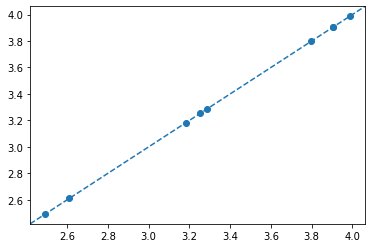

In [146]:
plt.scatter(m.predicted_alpha_dnms,m.Predicted_alpha_dnms)
identity_line()
#print(t2.Predicted_alpha_dnms.dropna())

<AxesSubplot:xlabel='Predicted_alpha_dnms', ylabel='dnm_alpha'>

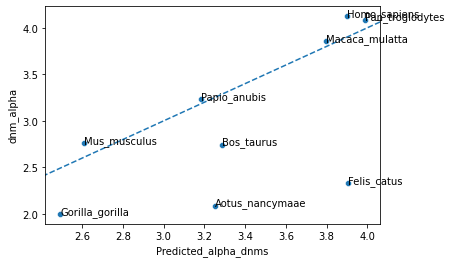

In [139]:
f,ax = plt.subplots()
sns.scatterplot(data=m,x="Predicted_alpha_dnms",y="dnm_alpha")
for i,r in m.iterrows():
    ax.annotate(r.Species, xy=(r.Predicted_alpha_dnms,r.dnm_alpha))
identity_line()
#plt.text()

In [140]:
#subd = data[(data.trios>1) & (data.Species!="Microcebus_murinus")].dropna()
stats.pearsonr(m.predicted_alpha_dnms, m.dnm_alpha)

(0.6403755689995244, 0.06317759813143359)

Add binomial CIs

In [6]:
data = data.reset_index(drop=True)
data = add_binomial_CIs(data)

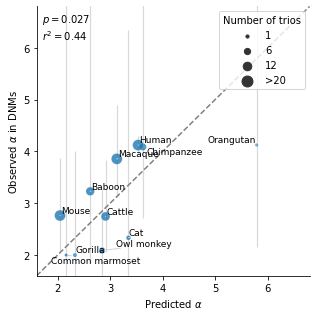

In [7]:
f,ax = plt.subplots(figsize=[4.5,4.5])
subd = data[~data.Species.isin(["Microcebus_murinus","Ficedula_albicollis"])]
max_size = 20
subd["Number of trios"] = [max_size if t>max_size else t for t in subd.trios]


sns.scatterplot(data=subd, x="predicted_alpha_dnms", y="dnm_alpha",ax=ax, alpha=0.8,
                size="Number of trios",
                sizes = (10,120),
                legend="full")#hue_norm=(0.1, max_size), 
identity_line(color="gray")

texts = [ax.text(r.predicted_alpha_dnms, r.dnm_alpha,r["Common_name"], size=9) for i,r in subd.iterrows()]
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='lightgray', linewidth=1),expand_text=[1.4,1.5]) #

ax.vlines(ymin=subd.low, ymax=subd.high, x=subd.predicted_alpha_dnms, linewidth=1.2, alpha=0.3, color="gray",zorder=0)

handles, labels = ax.get_legend_handles_labels()
ileg = [i for i,(h,l) in enumerate(zip(handles, labels)) if l in ["1", "6", "12", "20"]]
#ileg = [i for i,(h,l) in enumerate(zip(handles, labels)) if l in ["8", "12", "20"]]
ax.legend([handles[i] for i in ileg], [labels[i] if labels[i]!=str(max_size) else ">{}".format(labels[i]) for i in ileg], 
          loc="upper right",title="Number of trios")
#ax.legend(loc="lower right",title="Number of trios")

r1,pval = stats.pearsonr(subd.predicted_alpha_dnms, subd.dnm_alpha)
r2 = r1**2
ax.text(s = r"$p={:.3f}$".format(pval) + "\n" + r"$r^2={:.2f}$".format(r2),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color="black")

ax.set_xlabel(r"Predicted $\alpha$")
ax.set_ylabel(r"Observed $\alpha$ in DNMs")
sns.despine()

ax.set_xlim([1.6,6.8])
ax.set_ylim([1.6,6.8])
plt.tight_layout()
#f.savefig("pdfs/Model_vs_DNMs_size_noMouseLemur.pdf")

In [8]:
data.to_csv("../data/DNM_2exposure-model_alphas.csv")

In [12]:
rate_node2leaf = nearest_node2leaf(rate_phylo)
time_node2leaf = nearest_node2leaf(time_phylo)

In [13]:
species = ["Homo_sapiens","Mus_musculus", "Rattus_norvegicus","Canis_lupus","Felis_catus",'Mustela_putorius','Panthera_tigris','Bos_taurus','Equus_caballus','Colobus_angolensis']
for sp in species:
    time_dist = branch_specific_length(sp, time_node2leaf, time_phylo)
    rate_dist = branch_specific_length(sp, rate_node2leaf, rate_phylo)
    mut_per_year = (rate_dist/time_dist)/1e6
    print(mut_per_year, time_dist, rate_dist, sp)

8.970989662309115e-10 6.650905 0.00596652 Homo_sapiens
3.017378453429751e-09 3.06548222 0.00924972 Mus_musculus
4.1853762160179744e-09 20.8874174 0.0874217 Rattus_norvegicus
1.0953732714745479e-10 7.80599657 0.000855048 Canis_lupus
1.0187366010863221e-09 4.35333333 0.0044349 Felis_catus
1.5817428571428572e-09 17.5 0.0276805 Mustela_putorius
5.051642854034816e-10 7.41234111 0.00374445 Panthera_tigris
2.860629463956677e-09 0.62642157 0.00179196 Bos_taurus
4.4137065637065634e-10 2.59 0.00114315 Equus_caballus
7.3442265625e-10 12.8 0.00940061 Colobus_angolensis
